<a href="https://colab.research.google.com/github/MarioZZJ/PM.SimLab-DM/blob/master/L3_Association_Rule_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 实验任务
* 统计不同国家的销售量
* 整体的关联规则
* 主要的3个国家的关联规则有什么异同？

## 要求
* 输出关键分析步骤
* 使用support, confidence和lift

# 数据探索与预处理EDA&DP
## 载入数据和库

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori,association_rules
from mlxtend.preprocessing import TransactionEncoder
pd.options.display.latex.repr = True

In [3]:
data = pd.read_excel('./drive/MyDrive/PM.SimLab-DM/data/Online Retail.xlsx')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


由数据描述可知，载入数据共有 541908 条记录，8 个字段。一条记录代表某订单中某商品的购买记录，一笔订单由多条记录构成。根据本次数据挖掘的任务，有一些字段是我们不关心的，如仓库号 `stockCode` 、订单时间 `InvoiceDate` （订单号足以区分订单）、顾客编号 `CustomerID` ，可以将其去除。

In [6]:
data = data.iloc[:,[0,2,3,5,7]]

## 描述性分析

In [7]:
data.describe() # 离散型数据

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


可以看到商品数量和单价存在小于等于 0 的情况，属于异常记录，直接将其删除。

In [8]:
data = data[(data.Quantity > 0) & (data.UnitPrice > 0)]

In [9]:
data.shape

(530104, 5)

结合之前的分析可知，大部分的订单都是小数量小单价商品订单。

在对离散型数据进行描述性统计分析之前，先处理 `Description` 列的问题，在加载中发现其存在部分空值，且通过Excel打开数据文件可知还存在部分非有效商品描述：

![](http://download.mariozzj.cn/img/picgo/20210517200716.png)

**excel截图**

共性特征是 `Description` 含 `?` 。但是，他们的 `UnitPrice` 均为 0，所以已经去除了，因此只需要去除空值。

In [10]:
data = data.dropna()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    530104 non-null  object 
 1   Description  530104 non-null  object 
 2   Quantity     530104 non-null  int64  
 3   UnitPrice    530104 non-null  float64
 4   Country      530104 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 24.3+ MB


In [12]:
data.iloc[:,[0,1,4]].describe()# 离散型数据

,InvoiceNo,Description,Country
count,530104,530104,530104
unique,19960,4026,38
top,573585,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2323,485123


对离散型数据进行描述统计可知，共有 19960 笔订单，4026 种商品，38 个国家。

# 国家销售情况统计

In [13]:
quantity_country = data.groupby(by=['Country']).sum().sort_values(by=['Quantity']).iloc[:,[0]]

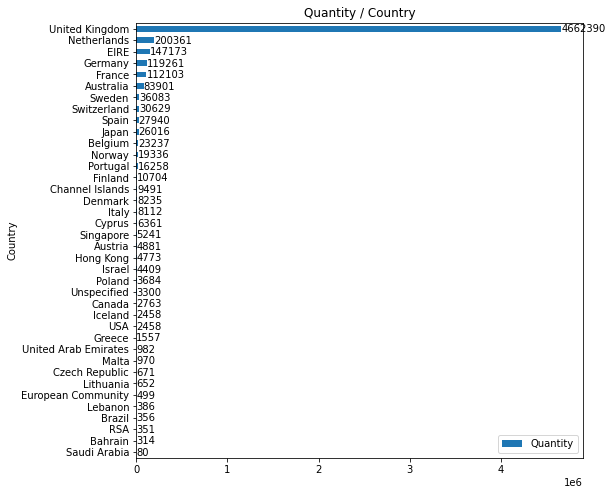

In [14]:
fig = quantity_country.plot(figsize=(8,8),kind='barh',title='Quantity / Country',ylabel='Quantity');i=0
for index,row in quantity_country.iterrows():
    fig.text(row.values[0],i-0.3,row.values[0]);i+=1
fig.legend(loc=4)

In [15]:
1-quantity_country.iloc[:-1].sum()/quantity_country.sum()

Quantity    0.834301
dtype: float64

可以看到，该数据的大部分销量都被 United Kindom 占据（83%），排名 2 ~ 5 位的国家为 Netherlands、EIRE、Germany、France，销量都在 100,000 以上。由于相对而言 United Kindom 相对占比过大，剩余国家柱形几乎不可见，所以可以考虑将其去除后展示其余国家的销量比例关系：

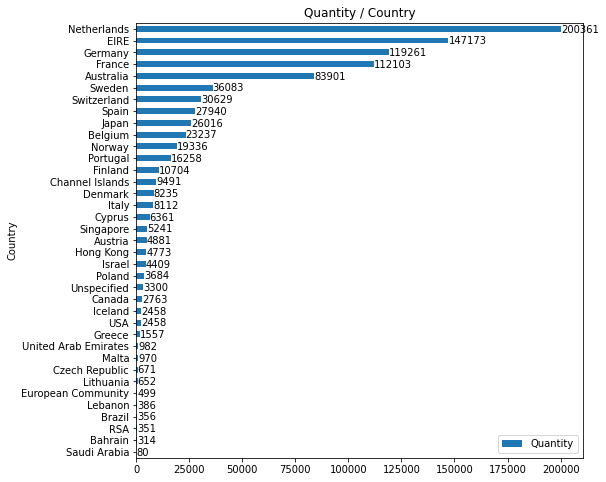

In [16]:
fig = quantity_country[:-1].plot(figsize=(8,8),kind='barh',title='Quantity / Country',ylabel='Quantity');i=0
for index,row in quantity_country.iterrows():
    if index == 'United Kingdom': break
    fig.text(row.values[0],i-0.3,row.values[0]);i+=1
fig.legend(loc=4)

由于本次任务是关联规则挖掘，还需要整理一下各国家的订单数量，方能够综合评价选择出比较重要的国家。

In [17]:
order_country = data.iloc[:,[0,4]].drop_duplicates('InvoiceNo').groupby(by='Country').count().sort_values(by='InvoiceNo')

In [18]:
1-order_country.iloc[:-1].sum()/order_country.sum()

InvoiceNo    0.902756
dtype: float64

In [19]:
order_country.iloc[-1]

InvoiceNo    18019
Name: United Kingdom, dtype: int64

United Kingdom 的订单同样占据了 90%，有 18019 条，不利于可视化，因此去除。

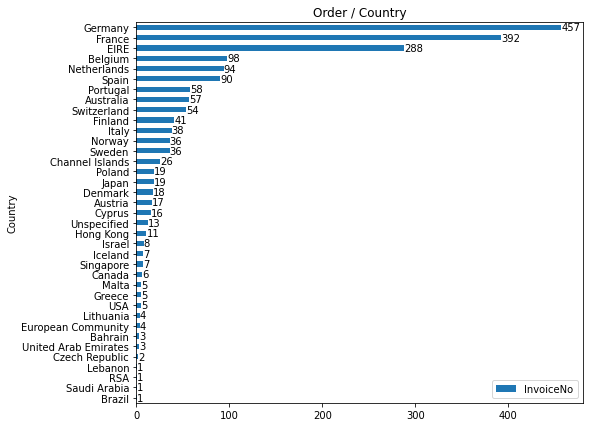

In [20]:
fig = order_country[:-1].plot(figsize=(8,7),kind='barh',title='Order / Country',ylabel='Order');i=0
for index,row in order_country.iterrows():
    if index =='United Kingdom' : break
    fig.text(row.values[0],i-0.3,row.values[0]);i+=1
fig.legend(loc=4)

从单量角度而言，靠前的国家类似，但排名略有不同。排名 2 ~ 5 位的国家为 Germany、France、EIRE、Belgium。

# 数据集整体关联规则挖掘

## 数据处理：提取并转化事务数据

根据之前的数据探索，目前的数据集中一条记录是订单中的一项商品的交易，而我们如果需要挖掘关联规则，则需要将相同订单的商品记录合并为一条订单记录。

In [21]:
data.iloc[:,:2].tail()

,InvoiceNo,Description
541904,581587,PACK OF 20 SPACEBOY NAPKINS
541905,581587,CHILDREN'S APRON DOLLY GIRL
541906,581587,CHILDRENS CUTLERY DOLLY GIRL
541907,581587,CHILDRENS CUTLERY CIRCUS PARADE
541908,581587,BAKING SET 9 PIECE RETROSPOT


In [22]:
prevIndex = -1; trans_list = []; trans = []
orderData = data.iloc[:,:2].set_index('InvoiceNo')
for index,row in orderData.iterrows():
    if index == prevIndex:
        trans.append(row[0])
    else: 
        prevIndex = index
        trans_list.append(trans)
        trans = []
        trans.append(row[0])

In [23]:
trans_list = trans_list[1:]

In [24]:
trans_list[:2]

[['WHITE HANGING HEART T-LIGHT HOLDER',
  'WHITE METAL LANTERN',
  'CREAM CUPID HEARTS COAT HANGER',
  'KNITTED UNION FLAG HOT WATER BOTTLE',
  'RED WOOLLY HOTTIE WHITE HEART.',
  'SET 7 BABUSHKA NESTING BOXES',
  'GLASS STAR FROSTED T-LIGHT HOLDER'],
 ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT']]

普通的关联规则分析中，我们只关注项目是否出现，而不关注其数量，因此生成了一个列表用于存储各个订单中出现的商品，消去了数量信息。


这里用于探索关联规则的是 `mlxtend` 包，含有 `apriori()`、`association_rules()` 等方法。

首先，可以利用 `TransactionEncoder()` 方法，将事务数据进一步转化为 `mlxtend` 可接收的输入形式。

In [25]:
encoder = TransactionEncoder()
X = encoder.fit_transform(trans_list)

实际上这一操作等同于 one-hot 编码，每一列代表一个商品在该订单中是否出现。

In [26]:
X[:2]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

可以查看encoder对应的参数：

In [27]:
print("Num of goods: %d " % len(encoder.columns_))
print(encoder.columns_[:3])

Num of goods: 4026 
[' 4 PURPLE FLOCK DINNER CANDLES', " 50'S CHRISTMAS GIFT BAG LARGE", ' DOLLY GIRL BEAKER']


编码后的参数表明，共有 4026 种商品，这与数据探索中一致。根据编码规则也生成了对应的列名，之后可以随时查看。

In [28]:
trans_data = pd.DataFrame(X, columns = encoder.columns_)

## 频繁项集挖掘：基于支持度

频繁项集是那些出现频次较高的项目集合，一般用支持度(support)来评价。

支持度指包含项目集合的事务占比，在本次任务中具体指的是订单中含有项目集合中的所有订单数量占总订单数量。由于数据中商品数量较多（4026 种），所以很有可能实际支持度绝对很高的项集不多，但是只要项集的支持度相对较高，就说明项集中隐藏的关联规则可能是相对而言重要的。

下面利用 `apriori()` 方法限定项集的最小支持度 `min_support`，探索那些可能较为重要的项目集合。

In [29]:
num_rec = []
for i in np.arange(0.01,0.15,0.01):
    result = apriori(trans_data, min_support=i)
    num_rec.append(result.shape[0])

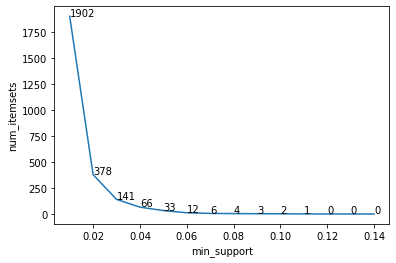

In [30]:
plt.plot(np.arange(0.01,0.15,0.01),num_rec)
plt.xlabel("min_support");plt.ylabel("num_itemsets")
for i in range(len(np.arange(0.01,0.15,0.01))):
    plt.text(np.arange(0.01,0.15,0.01)[i],num_rec[i]+5,str(num_rec[i]))

可以看到，在整体数据集中，随着最小支持度线性上升，满足条件的项目集合数几乎是呈指数型下降。

In [31]:
result_list = []
for i in np.arange(0.01,0.05,0.01):
    result = apriori(trans_data, min_support=i)
    result.iloc[:,1] = result.iloc[:,1].apply(lambda x: len(x))
    result.columns=['itemsets_count','item_count']
    a = result.groupby(by='item_count').count().T
    display(a)

item_count,1,2,3,4,5
itemsets_count,810,840,233,18,1


item_count,1,2,3
itemsets_count,296,79,3


item_count,1,2
itemsets_count,133,8


item_count,1,2
itemsets_count,65,1


以上分别展示了支持度分别为 0.01、0.02、0.03、0.04 时抽出的频繁项集中含有的商品数和对应的商品数量相同的频繁项集数量。需要明确的是，我需要挖掘出的是规则，而只有 1 个商品的项集由于不可分出两个都不是空集的互斥子集，所以对于挖掘任务无帮助，**需要重点关注的则是那些含有 2 个及以上商品的项集**，从它们中间抽取出规则，检验这些规则的置信度。

可以看到，限定最小支持度为 0.01、0.02、0.03 时可以获取得到许多含 2 个及以上商品的项集。因为含有d个项目的数据集有 $2^d$ 种可能的关联规则，为了研究方便，选择最小支持度 0.02 的结果继续进行关联规则挖掘。

In [32]:
freq_itemset = apriori(trans_data, min_support=0.02,use_colnames= True)

## 关联规则挖掘：基于置信度

对于频繁项目集合 $X$ 可以分割为两个非空子集 $X_1$、$X_2$（$X=X_1 + X_2$），得到关联规则 $X_1\to X_2$ 或 $X_2\to X_1$。

对于规则 $X_1\to X_2$，其支持度为同时包含 $X_1$ 和 $X_2$ 的事务占比，实际上就是频繁项集 $X$ 的支持度；

而其置信度(confidence)则是 $X_2$ 出现的条件概率，即所有事务数据中，包含 $X_1$ 的交易中同时出现 $X_2$ 的概率。

所以在确定了频繁项集的情况下，可以利用置信度来挖掘较重要的规则。最基础的关联规则挖掘任务就是在确定满足以下条件的规则：

1. 规则支持度不小于设定的最小支持度
2. 规则置信度不小于设定的最小置信度





下面，继续利用 `mixtend` 包的 `association_rules()` 方法挖掘关联规则。可通过 `min_threshold` 参数过滤那些置信度小于我们设定的规则。

In [33]:
rule_count = []
for i in np.arange(0.1,0.81,0.05):
    rules = association_rules(freq_itemset,metric = 'confidence',min_threshold = i)
    rule_count.append(rules.shape[0])

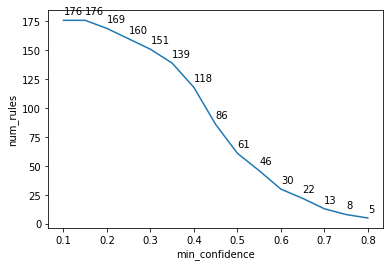

In [34]:
plt.plot(np.arange(0.1,0.81,0.05),rule_count)
plt.xlabel("min_confidence");plt.ylabel("num_rules")
for i in range(len(np.arange(0.1,0.81,0.05))):
    plt.text(np.arange(0.1,0.81,0.05)[i],rule_count[i]+5,str(rule_count[i]))

通过对规则添加置信度限制，可以筛选出置信度较高的规则，下面展示置信度非常高（$\text{confidence}\ge 0.7$）的13条规则：

In [35]:
rules = association_rules(freq_itemset,metric = 'confidence',min_threshold = 0.7)

In [36]:
rules.columns

Index(['antecedents', 'consequents', 'antecedent support',
       'consequent support', 'support', 'confidence', 'lift', 'leverage',
       'conviction'],
      dtype='object')

In [37]:
rules.iloc[:,[0,1,4,5,6]].sort_values(by="confidence",ascending=False).round(3)

,antecedents,consequents,support,confidence,lift
6,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.027,0.905,17.825
7,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.027,0.856,16.042
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.032,0.826,16.277
12,"(JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUKI)",(JUMBO BAG RED RETROSPOT),0.021,0.802,7.662
11,"(REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...",(ROSES REGENCY TEACUP AND SAUCER ),0.020,0.802,15.022
5,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.030,0.782,14.650
10,"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...",(GREEN REGENCY TEACUP AND SAUCER),0.020,0.777,15.312
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.038,0.757,14.190
1,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.027,0.720,15.747
3,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.038,0.720,14.190


3 款不同颜色的茶杯和茶碟组成的频繁项集生成的 3 条关联规则在提取出的规则之间置信度最高，这条规则说明该电商渠道的顾客当需要买茶杯时，很可能会 3 种颜色的茶杯一同购买。就此产生的用以指导销售的策略可能是注意补齐缺货颜色，尽量保证各种颜色的茶杯都有货，这样顾客就会购买多种颜色的茶杯，增加销量。

还有的规则是 JUMBO 牌收纳袋不同颜色之间的关联规则，原因与上述类似；还有同时购买茶杯和蛋糕架的规则，可以利用此规则调整销售策略。

但是观察所有支持度大于0.02，置信度大于0.70的规则也可以看出，总共涉及到的商品类别也有限，而且规则也大多局限于一种商品的不同颜色款式，可能规则相对于理想状态下的示例（如啤酒、尿布例子）不是很有趣，我认为这主要是数据集的商品粒度过细的原因，如果我们想挖掘出“更有意思”的规则，应该对不同品牌、不同颜色的同品类商品进行合并；但是“没有意思”的规则并不意味着没有应用价值，只要对目标策略调整具有指导性意义的规则，就是好的规则。

## 关联规则挖掘：基于提升度

上一节筛选关联规则时，使用的评价指标是 confidence，这一指标在规则中（项集中）某些项目本身出现频率较高时有误导性，即有可能 $\text{confidence=}P(X_1|X_2)$ 看起来很高，但是因为 $P(X_1)$ 本身很高且 $P(X_2)$ 不是很高，实际上 $P(X_1|\bar{X_2}) \gt P(X_1|X_2)$。

引入提升度(lift)可以解决这个问题，提升度在计算时考虑了统计独立性，相比于 confidence 略科学。它衡量的是一个规则对目标中“响应”的预测能力优于随机选择的倍数.

$$
\text{lift}(X_1|X_2)=\dfrac{P(X_1|X_2)}{P(X_1)}
$$

下面，利用 `mlxtend` 包的 `association_rules()` 方法挖掘关联规则。可通过 `min_threshold` 参数过滤那些提升度小于我们设定的规则。

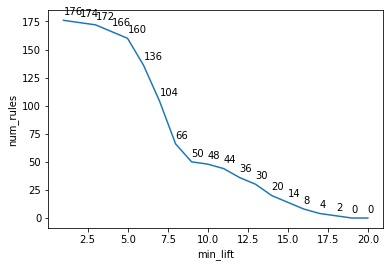

In [38]:
rule_count = []
for i in np.arange(0.99,20,1):
    rules = association_rules(freq_itemset,metric = 'lift',min_threshold = i)
    rule_count.append(rules.shape[0])

plt.plot(np.arange(0.99,20,1),rule_count)
plt.xlabel("min_lift");plt.ylabel("num_rules")
for i in range(len(np.arange(0.99,20,1))):
    plt.text(np.arange(0.99,20,1)[i],rule_count[i]+5,str(rule_count[i]))

In [39]:
rules = association_rules(freq_itemset,metric = 'lift',min_threshold = 14.99)

In [40]:
rules.iloc[:,[0,1,4,5,6]].sort_values(by="lift",ascending=False).round(3)

,antecedents,consequents,support,confidence,lift
6,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.027,0.705,18.403
7,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.027,0.707,18.403
4,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.027,0.905,17.825
9,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.027,0.534,17.825
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.032,0.624,16.277
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.032,0.826,16.277
5,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.027,0.856,16.042
8,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.027,0.508,16.042
0,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.027,0.598,15.747
1,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.027,0.720,15.747


相比而言，同样支持度限制下，使用提升度和置信度提取得到的规则中包含的商品类似，但是排名不同；可以看出提升度较高的规则也说明了同品类不同款式的组合销售非常重要。

# 分国家数据关联规则挖掘

可选择主要的三个国家进行各自国家内部订单的关联规则分析，得出不同市场的特点；但是由于数据集中 United Kingdom 数据单量与其他国家过于悬殊，直接对比可能得出意义较小的结论，所以选择订单量较多且订单量处于同一数量级的德国（Germany，单量457）、法国（France，单量392）、爱尔兰（EIRE，单量288）的数据进行分析，过程与整个数据集的分析类似。

In [41]:
data_germany = data[data.Country=='Germany']
data_france = data[data.Country=='France']
data_eire = data[data.Country=='EIRE']

## 关联规则挖掘：法国

In [42]:
prevIndex = -1; trans_list = []; trans = []
orderData = data_france.iloc[:,:2].set_index('InvoiceNo')
for index,row in orderData.iterrows():
    if index == prevIndex:
        trans.append(row[0])
    else: 
        prevIndex = index
        trans_list.append(trans)
        trans = []
        trans.append(row[0])
trans_list = trans_list[1:]
encoder = TransactionEncoder()
X = encoder.fit_transform(trans_list)
print("Num of goods: %d \nGoods Sample:" % len(encoder.columns_))
print(encoder.columns_[:3])
trans_data = pd.DataFrame(X, columns = encoder.columns_)

Num of goods: 1564 
Goods Sample:
[" 50'S CHRISTMAS GIFT BAG LARGE", ' DOLLY GIRL BEAKER', ' I LOVE LONDON MINI BACKPACK']


In [43]:
num_rec = []
for i in np.arange(0.05,0.24,0.03):
    result = apriori(trans_data, min_support=i)
    num_rec.append(result.shape[0])
    result.iloc[:,1] = result.iloc[:,1].apply(lambda x: len(x))
    result.columns=['itemsets_count','item_count']
    a = result.groupby(by='item_count').count().T
    print("Support: %.3f" % i)
    display(a)

Support: 0.050


item_count,1,2,3,4
itemsets_count,76,93,22,3


Support: 0.080


item_count,1,2,3,4
itemsets_count,32,33,6,1


Support: 0.110


item_count,1,2
itemsets_count,19,12


Support: 0.140


item_count,1,2
itemsets_count,8,4


Support: 0.170


item_count,1
itemsets_count,4


Support: 0.200


item_count,1
itemsets_count,1


Support: 0.230


item_count,1
itemsets_count,1


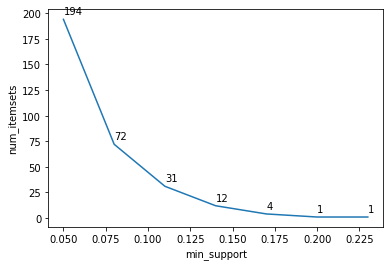

In [44]:
plt.plot(np.arange(0.05,0.24,0.03),num_rec)
plt.xlabel("min_support");plt.ylabel("num_itemsets")
for i in range(len(np.arange(0.05,0.24,0.03))):
    plt.text(np.arange(0.05,0.24,0.03)[i],num_rec[i]+5,str(num_rec[i]))

可以看到，通过国家筛选，整体商品种类数变少，复杂度降低，可设定的最小支持度也上升了。

选定最小支持度为 0.08 的频繁项集进行后续分析。

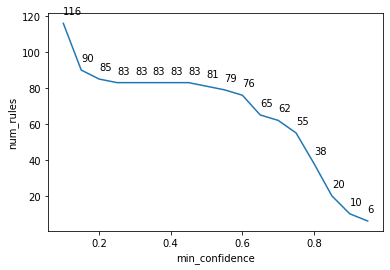

In [45]:
freq_itemset = apriori(trans_data, min_support=0.08,use_colnames= True)
rule_count = []
for i in np.arange(0.1,0.96,0.05):
    rules = association_rules(freq_itemset,metric = 'confidence',min_threshold = i)
    rule_count.append(rules.shape[0])
plt.plot(np.arange(0.1,0.96,0.05),rule_count)
plt.xlabel("min_confidence");plt.ylabel("num_rules")
for i in range(len(np.arange(0.1,0.96,0.05))):
    plt.text(np.arange(0.1,0.96,0.05)[i],rule_count[i]+5,str(rule_count[i])) # 这个真的是置信度吗？

In [46]:
rules = association_rules(freq_itemset,metric = 'confidence',min_threshold = 0.90)
rules.iloc[:,[0,1,4,5,6]].sort_values(by="confidence",ascending=False).round(3)

,antecedents,consequents,support,confidence,lift
6,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.100,0.975,7.624
7,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.100,0.975,7.060
8,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.082,0.970,7.583
9,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.082,0.970,7.021
4,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.123,0.960,6.951
5,"(SET/6 RED SPOTTY PAPER PLATES, POSTAGE)",(SET/6 RED SPOTTY PAPER CUPS),0.102,0.952,6.896
3,(TEA PARTY BIRTHDAY CARD),(POSTAGE),0.090,0.946,1.233
0,(ALARM CLOCK BAKELIKE RED ),(POSTAGE),0.087,0.944,1.231
2,(STRAWBERRY LUNCH BOX WITH CUTLERY),(POSTAGE),0.115,0.937,1.222
1,(ROUND SNACK BOXES SET OF4 WOODLAND ),(POSTAGE),0.148,0.935,1.219


分国家得出的关联规则看上去更有趣，或许是复杂度降低的原因，且整体置信度条件都较全部数据集好。

可以看出，从德国数据中抽取出的关联规则靠前者的种类较多。

1. 日用品搭配购买：例如消费者通常会一同购买纸杯、纸盘、餐巾纸。
2. 邮资服务：规则(3),(0),(2),(1)中，购买前者（礼物物件）时，都会和“邮资”一同购买。（当然，“邮资”这种项目应该在数据处理中去掉，不过也能够揭示一定的地区特征）

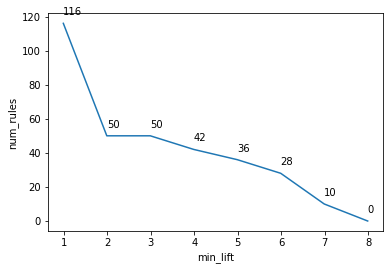

In [47]:
rule_count = []
for i in np.arange(0.99,8,1):
    rules = association_rules(freq_itemset,metric = 'lift',min_threshold = i)
    rule_count.append(rules.shape[0])

plt.plot(np.arange(0.99,8,1),rule_count)
plt.xlabel("min_lift");plt.ylabel("num_rules")
for i in range(len(np.arange(0.99,8,1))):
    plt.text(np.arange(0.99,8,1)[i],rule_count[i]+5,str(rule_count[i]))

而从提升度角度，法国数据的整体提升度比整体数据集低，大多在 8 以下。

In [48]:
rules = association_rules(freq_itemset,metric = 'lift',min_threshold = 6.99)
rules.iloc[:,[0,1,4,5,6]].sort_values(by="lift",ascending=False).round(3)

,antecedents,consequents,support,confidence,lift
0,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.100,0.975,7.624
3,(SET/6 RED SPOTTY PAPER PLATES),"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.100,0.780,7.624
4,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.082,0.970,7.583
9,(SET/6 RED SPOTTY PAPER PLATES),"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.082,0.640,7.583
7,"(SET/6 RED SPOTTY PAPER PLATES, POSTAGE)","(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.082,0.762,7.448
6,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...","(SET/6 RED SPOTTY PAPER PLATES, POSTAGE)",0.082,0.800,7.448
1,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.100,0.975,7.060
2,(SET/6 RED SPOTTY PAPER CUPS),"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",0.100,0.722,7.060
5,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.082,0.970,7.021
8,(SET/6 RED SPOTTY PAPER CUPS),"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",0.082,0.593,7.021


使用提升度筛选得到的关联规则与使用置信度得到的关联规则类似，不再赘述。

## 关联规则挖掘：德国

In [49]:
prevIndex = -1; trans_list = []; trans = []
orderData = data_germany.iloc[:,:2].set_index('InvoiceNo')
for index,row in orderData.iterrows():
    if index == prevIndex:
        trans.append(row[0])
    else: 
        prevIndex = index
        trans_list.append(trans)
        trans = []
        trans.append(row[0])
trans_list = trans_list[1:]
encoder = TransactionEncoder()
X = encoder.fit_transform(trans_list)
print("Num of goods: %d \nGoods Sample:" % len(encoder.columns_))
print(encoder.columns_[:3])
trans_data = pd.DataFrame(X, columns = encoder.columns_)

Num of goods: 1695 
Goods Sample:
[" 50'S CHRISTMAS GIFT BAG LARGE", ' DOLLY GIRL BEAKER', ' I LOVE LONDON MINI BACKPACK']


德国数据内，同样，商品种类数比整个数据集少一半。

In [50]:
num_rec = []
for i in np.arange(0.05,0.24,0.03):
    result = apriori(trans_data, min_support=i)
    num_rec.append(result.shape[0])
    result.iloc[:,1] = result.iloc[:,1].apply(lambda x: len(x))
    result.columns=['itemsets_count','item_count']
    a = result.groupby(by='item_count').count().T
    print("Support: %.3f" % i)
    display(a)

Support: 0.050


item_count,1,2,3
itemsets_count,51,43,8


Support: 0.080


item_count,1,2,3
itemsets_count,14,12,1


Support: 0.110


item_count,1,2,3
itemsets_count,7,6,1


Support: 0.140


item_count,1,2
itemsets_count,3,2


Support: 0.170


item_count,1,2
itemsets_count,2,1


Support: 0.200


item_count,1,2
itemsets_count,2,1


Support: 0.230


item_count,1
itemsets_count,2


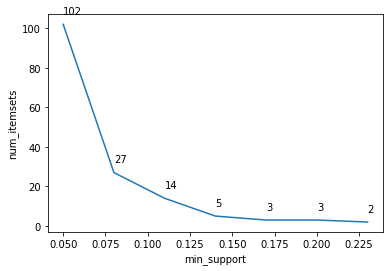

In [51]:
plt.plot(np.arange(0.05,0.24,0.03),num_rec)
plt.xlabel("min_support");plt.ylabel("num_itemsets")
for i in range(len(np.arange(0.05,0.24,0.03))):
    plt.text(np.arange(0.05,0.24,0.03)[i],num_rec[i]+5,str(num_rec[i]))

德国数据中，支持度的分布与法国不太一样，很多的项集支持度集中在0.1以下，说明可能德国的订单数据本身有较为零散的特点。

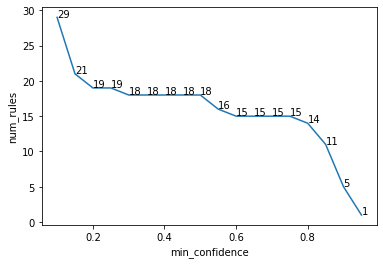

In [52]:
freq_itemset = apriori(trans_data, min_support=0.08,use_colnames= True)
rule_count = []
for i in np.arange(0.1,0.96,0.05):
    rules = association_rules(freq_itemset,metric = 'confidence',min_threshold = i)
    rule_count.append(rules.shape[0])
plt.plot(np.arange(0.1,0.96,0.05),rule_count)
plt.xlabel("min_confidence");plt.ylabel("num_rules")
for i in range(len(np.arange(0.1,0.96,0.05))):
    plt.text(np.arange(0.1,0.96,0.05)[i],rule_count[i]+0.1,str(rule_count[i])) # 这个真的是置信度吗？

In [53]:
rules = association_rules(freq_itemset,metric = 'confidence',min_threshold = 0.80)
rules.iloc[:,[0,1,4,5,6]].sort_values(by="confidence",ascending=False).round(3)

,antecedents,consequents,support,confidence,lift
7,(ROUND SNACK BOXES SET OF 4 FRUITS ),(POSTAGE),0.151,0.958,1.172
13,"(ROUND SNACK BOXES SET OF 4 FRUITS , ROUND SNA...",(POSTAGE),0.125,0.950,1.161
3,(PLASTERS IN TIN SPACEBOY),(POSTAGE),0.101,0.939,1.148
8,(ROUND SNACK BOXES SET OF4 WOODLAND ),(POSTAGE),0.226,0.920,1.124
10,(WOODLAND CHARLOTTE BAG),(POSTAGE),0.116,0.914,1.117
0,(6 RIBBONS RUSTIC CHARM),(POSTAGE),0.092,0.894,1.092
9,(SPACEBOY LUNCH BOX ),(POSTAGE),0.092,0.894,1.092
6,(REGENCY CAKESTAND 3 TIER),(POSTAGE),0.121,0.873,1.067
1,(JUMBO BAG WOODLAND ANIMALS),(POSTAGE),0.088,0.870,1.063
2,(PLASTERS IN TIN CIRCUS PARADE ),(POSTAGE),0.099,0.865,1.058


以置信度对结果进行筛选，得到的靠前的规则记录都为购买单物品者都会购买邮资，推测这可能是因为商品本身价格过低，没有达到“包邮”门槛。这样一条规则其实没有什么应用价值，仅仅可以解读购买这些商品的客户愿意付邮费。也可以从这些规则的提升度看出，虽然都大于 1，是正向促进的，但是都不高。而最后两行的盒装零食搭配购买规则虽然置信度没有前面高，但是提升度却显著大于上面的“凑邮费”规则。

下面通过提升度筛选更重要的规则：

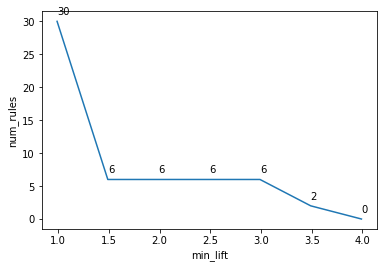

In [54]:
rule_count = []
for i in np.arange(0.99,4,0.5):
    rules = association_rules(freq_itemset,metric = 'lift',min_threshold = i)
    rule_count.append(rules.shape[0])

plt.plot(np.arange(0.99,4,0.5),rule_count)
plt.xlabel("min_lift");plt.ylabel("num_rules")
for i in range(len(np.arange(0.99,4,0.5))):
    plt.text(np.arange(0.99,4,0.5)[i],rule_count[i]+1,str(rule_count[i]))

德国数据集上，提升度普遍不是很高。不过也可以从中选出相对重要的规则。

In [55]:
rules = association_rules(freq_itemset,metric = 'lift',min_threshold = 1.17)
rules.iloc[:,[0,1,4,5,6]].sort_values(by="lift",ascending=False).round(3)

,antecedents,consequents,support,confidence,lift
5,"(POSTAGE, ROUND SNACK BOXES SET OF4 WOODLAND )",(ROUND SNACK BOXES SET OF 4 FRUITS ),0.125,0.553,3.505
6,(ROUND SNACK BOXES SET OF 4 FRUITS ),"(POSTAGE, ROUND SNACK BOXES SET OF4 WOODLAND )",0.125,0.792,3.505
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.132,0.833,3.393
3,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.132,0.536,3.393
4,"(ROUND SNACK BOXES SET OF 4 FRUITS , POSTAGE)",(ROUND SNACK BOXES SET OF4 WOODLAND ),0.125,0.826,3.363
7,(ROUND SNACK BOXES SET OF4 WOODLAND ),"(ROUND SNACK BOXES SET OF 4 FRUITS , POSTAGE)",0.125,0.509,3.363
0,(ROUND SNACK BOXES SET OF 4 FRUITS ),(POSTAGE),0.151,0.958,1.172
1,(POSTAGE),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.151,0.185,1.172


德国数据集的提升度分布出现了断层，不存在规则的提升度在 1.172 至 3.363 之间。而提升度大于 3.363 的规则集主要解揭示的是零食礼盒的组合购买，人们会倾向于购买 ROUND SNACK BOXES 的不同品种，同时也会出现需要加邮费的情况，可能是物品重量原因，也可能是物品价格和电商平台规则原因。  

## 关联规则挖掘：爱尔兰

In [56]:
prevIndex = -1; trans_list = []; trans = []
orderData = data_eire.iloc[:,:2].set_index('InvoiceNo')
for index,row in orderData.iterrows():
    if index == prevIndex:
        trans.append(row[0])
    else: 
        prevIndex = index
        trans_list.append(trans)
        trans = []
        trans.append(row[0])
trans_list = trans_list[1:]
encoder = TransactionEncoder()
X = encoder.fit_transform(trans_list)
print("Num of goods: %d \nGoods Sample:" % len(encoder.columns_))
print(encoder.columns_[:3])
trans_data = pd.DataFrame(X, columns = encoder.columns_)

Num of goods: 2006 
Goods Sample:
[' 4 PURPLE FLOCK DINNER CANDLES', " 50'S CHRISTMAS GIFT BAG LARGE", ' DOLLY GIRL BEAKER']


In [57]:
num_rec = []
for i in np.arange(0.05,0.24,0.03):
    result = apriori(trans_data, min_support=i)
    num_rec.append(result.shape[0])
    result.iloc[:,1] = result.iloc[:,1].apply(lambda x: len(x))
    result.columns=['itemsets_count','item_count']
    a = result.groupby(by='item_count').count().T
    print("Support: %.3f" % i)
    display(a)

Support: 0.050


item_count,1,2,3,4
itemsets_count,79,44,26,5


Support: 0.080


item_count,1,2,3
itemsets_count,24,5,2


Support: 0.110


item_count,1,2
itemsets_count,11,2


Support: 0.140


item_count,1
itemsets_count,5


Support: 0.170


item_count,1
itemsets_count,2


Support: 0.200


item_count,1
itemsets_count,2


Support: 0.230


item_count,1
itemsets_count,2


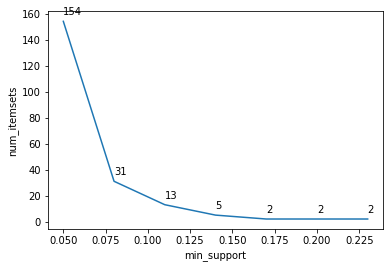

In [58]:
plt.plot(np.arange(0.05,0.24,0.03),num_rec)
plt.xlabel("min_support");plt.ylabel("num_itemsets")
for i in range(len(np.arange(0.05,0.24,0.03))):
    plt.text(np.arange(0.05,0.24,0.03)[i],num_rec[i]+5,str(num_rec[i]))

可以看到，通过国家筛选，整体商品种类数变少，复杂度降低，可设定的最小支持度也上升了。

选定最小支持度为 0.08 的频繁项集进行后续分析。

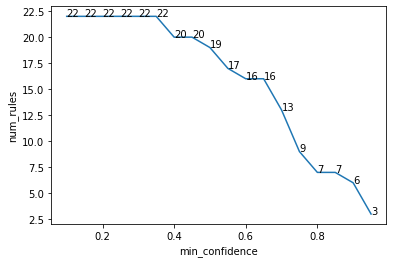

In [59]:
freq_itemset = apriori(trans_data, min_support=0.08,use_colnames= True)
rule_count = []
for i in np.arange(0.1,0.96,0.05):
    rules = association_rules(freq_itemset,metric = 'confidence',min_threshold = i)
    rule_count.append(rules.shape[0])
plt.plot(np.arange(0.1,0.96,0.05),rule_count)
plt.xlabel("min_confidence");plt.ylabel("num_rules")
for i in range(len(np.arange(0.1,0.96,0.05))):
    plt.text(np.arange(0.1,0.96,0.05)[i],rule_count[i],str(rule_count[i])) # 这个真的是置信度吗？

In [60]:
rules = association_rules(freq_itemset,metric = 'confidence',min_threshold = 0.75)
rules.iloc[:,[0,1,4,5,6]].sort_values(by="confidence",ascending=False).round(3)

,antecedents,consequents,support,confidence,lift
8,"(REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...",(ROSES REGENCY TEACUP AND SAUCER ),0.087,1.000,6.106
2,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.091,0.963,5.880
4,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.084,0.960,5.862
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.087,0.926,7.593
3,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.084,0.923,7.569
1,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.111,0.914,5.583
6,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.084,0.889,7.972
7,"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...",(GREEN REGENCY TEACUP AND SAUCER),0.087,0.781,6.406
9,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(REGENCY CAKESTAND 3 TIER),0.087,0.781,3.203
5,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.084,0.750,7.972


从爱尔兰抽出的置信度靠前的规则，和全部数据中抽出的规则类似，可能是因为爱尔兰市场特点接近英国市场特点。重要规则主要是不同颜色的茶杯、蛋糕架的共同购买。

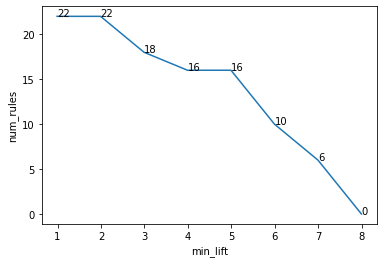

In [61]:
rule_count = []
for i in np.arange(0.99,8,1):
    rules = association_rules(freq_itemset,metric = 'lift',min_threshold = i)
    rule_count.append(rules.shape[0])

plt.plot(np.arange(0.99,8,1),rule_count)
plt.xlabel("min_lift");plt.ylabel("num_rules")
for i in range(len(np.arange(0.99,8,1))):
    plt.text(np.arange(0.99,8,1)[i],rule_count[i],str(rule_count[i]))

而从提升度角度，爱尔兰数据的整体提升度比整体数据集低，大多在 8 以下。

In [62]:
rules = association_rules(freq_itemset,metric = 'lift',min_threshold = 5.99)
rules.iloc[:,[0,1,4,5,6]].sort_values(by="lift",ascending=False).round(3)

,antecedents,consequents,support,confidence,lift
3,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.084,0.750,7.972
4,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.084,0.889,7.972
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.087,0.926,7.593
1,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.087,0.714,7.593
2,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.084,0.923,7.569
5,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.084,0.686,7.569
6,"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...",(GREEN REGENCY TEACUP AND SAUCER),0.087,0.781,6.406
9,(GREEN REGENCY TEACUP AND SAUCER),"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...",0.087,0.714,6.406
8,(ROSES REGENCY TEACUP AND SAUCER ),"(REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...",0.087,0.532,6.106
7,"(REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...",(ROSES REGENCY TEACUP AND SAUCER ),0.087,1.000,6.106


使用提升度筛选得到的关联规则与使用置信度得到的关联规则，排名略有变化，但提取出的结论相对而言相差无几。

## 关联规则对比

共性：
1. 就本数据集而言，3 个及以上项集形成的关联规则在提升度、置信度上比较接近，所以会出现靠前排名中的规则引出同类结论的情况。
2. 对于一些家居用品，顾客会倾向于购买同一商品的不同款式、颜色。

差异性：
1. 置信度、提升度水平方面，法国子数据集挖掘出的关联规则表现较好；德国的置信度、提升度整体偏低，且出现了提升度断层的情况，说明该电商的德国市场用户中的潜在行为规律较难获取，也有可能是出现了数据缺失的情况。
2. 德国市场顾客购买商品需要邮资的现象较多，法国则次之，这可能与该电商平台的物流选择有关，在不同国家可能有不同的物流成本；或许与不同国家用户的购买习惯有关，德国市场顾客可能更愿意支付邮资费用。
3. 爱尔兰市场的规则规律与整体数据集比较接近，又已知整体数据集的规律大体上是由占主导市场的英国确定的，所以可以得出爱尔兰顾客的购买习惯可能和英国顾客类似，二者在地理位置上也比较接近，商品类型大概率也是接近的。

# 实验总结

1. 完成了各项实验要求，通过实验进一步回顾了关联规则挖掘的常见算法和原理，并用实际数据进行了规则挖掘，掌握了评价频繁项集和规则的各项指标。
2. `mlxtend` 包自带`apriori`算法计算和规则挖掘方法，可以自行调整参数，给实验提供了便利。理解了事务数据的处理和转化，以及挖掘方法。把控好项集和规则的评价指标非常重要，通过调参，理解了设置支持度、置信度、提升度对结果数量分布的控制，也间接理解了控制参数对计算复杂度的影响。
3. 利用关联规则挖掘结果可以进行推荐、营销策略调整等，更具有现实意义。

实验不足：

1. 仅仅是调用程序包和调参，没有去体会比较关键的算法内部优化，即剪枝、优化存储、加速计算方法等。
2. 关联规则挖掘是无监督的，评价参数自行指定，可能存在参数选取不当导致结论不佳的情况，也有可能因为参数的限制，忽略了哪些稀有但重要的案例。